# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**


In [0]:
#mount google drive
from google.colab import drive
drive.mount('/gdrive')

#check files
!ls -la '/gdrive/My Drive/Case Study MLPS/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
total 823153
-rw------- 1 root root 267687592 Apr 26 17:18  clean_data.pickle
-rw------- 1 root root   1208381 Apr 26 17:18 'CS-Phase 2.ipynb'
-rw------- 1 root root    610800 May  3 12:32 'CS-Phase 3.ipynb'
-rw------- 1 root root       355 Apr 26 17:19 'MLPS Phase 3.ipynb'
-rw------- 1 root root         1 May  1 20:20 'Phase 3 Write-up.gdoc'
-rw------- 1 root root         1 Apr 12 21:05 'Phase II Write-Up.gdoc'
-rw------- 1 root root 573399301 Apr 29 23:16  pre_clean_data.pickle


In [0]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [0]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [0]:
default_seed = 1
output_file = "output_sample"

In [0]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [0]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "/gdrive/My Drive/Case Study MLPS/clean_data.pickle", "rb" ) )

In [0]:
data.head(5)

id  loan_amnt  funded_amnt        term  int_rate  installment grade  \
0  1077501     5000.0       5000.0   36 months     10.65       162.87     B   
1  1077430     2500.0       2500.0   60 months     15.27        59.83     C   
2  1077175     2400.0       2400.0   36 months     15.96        84.33     C   
3  1076863    10000.0      10000.0   36 months     13.49       339.31     C   
4  1075358     3000.0       3000.0   60 months     12.69        67.79     B   

  emp_length home_ownership  annual_inc  ... revol_util   total_pymnt  \
0  10+ years           RENT     24000.0  ...       83.7   5863.155187   
1   < 1 year           RENT     30000.0  ...        9.4   1014.530000   
2  10+ years           RENT     12252.0  ...       98.5   3005.666844   
3  10+ years           RENT     49200.0  ...       21.0  12231.890000   
4     1 year           RENT     80000.0  ...       53.9   4066.908161   

  last_pymnt_d recoveries  loan_length  term_num  ret_PESS   ret_OPT  \
0   2015-01-01        0.0         37.0        36  0.057544  0.055988   
1   2013-04-01      122.9         16.0        60 -0.118838 -0.118838   
2   2014-06-01        0.0         30.0        36  0.084120  0.100944   
3   2015-01-01        0.0         37.0        36  0.074396  0.072386   
4   2017-01-01        0.0         61.0        60  0.071127  0.069961   

   ret_INTa  ret_INTb  
0  0.054605  0.088148  
1 -0.110200 -0.095511  
2  0.073803  0.113007  
3  0.065582  0.100571  
4  0.087479  0.114530  

[5 rows x 32 columns]

In [0]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = np.where(data['loan_status'].isin(['Charged Off', 'Default']), True, False)

In [0]:
# Create a feature for the length of a person's credit history at the time the loan is issued
continuous_features = list(continuous_features)
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [0]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
data['train'] = np.random.choice([True, False], len(data), p=[0.7, 0.3])

In [0]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## Prepare functions to fit and evaluate models

In [0]:
# see 3.1.2. in the PDF for an explanation of the split
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [0]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred, 'accuracy':accuracy_score(y_test, y_pred), 'ROC':roc_auc_score(y_test, y_pred_probs)}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## 3.1.1. Train and Test different machine learning classification models 

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [0]:
## define your set of features to use in different models

# your_features = ['grade', 'purpose', 'term', 'emp_length', 'fico_range_high', 'revol_util', 'cr_hist']
your_features = list(discrete_features + continuous_features)

# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### Naive Bayes

  Model: gnb
Fit time: 0.2 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8035
              precision    recall  f1-score   support

  No default     0.8035    1.0000    0.8910     16070
     Default     0.0000    0.0000    0.0000      3930

   micro avg     0.8035    0.8035    0.8035     20000
   macro avg     0.4017    0.5000    0.4455     20000
weighted avg     0.6456    0.8035    0.7160     20000



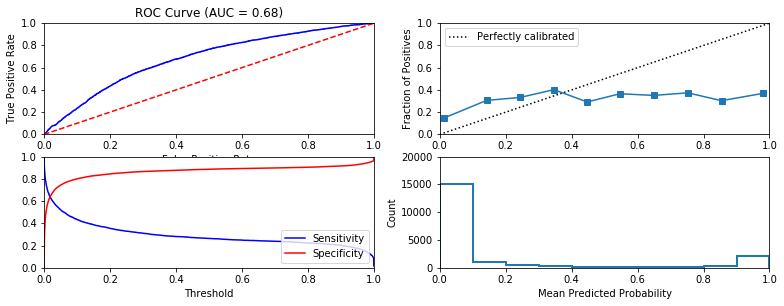


Similarity to LC grade ranking:  0.6502741893028391
Brier score: 0.21066434263024053
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.76266667]


In [0]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict, model_name='gnb')

### $l_1$ regularized logistic regression

  Model: Logisitic Regression
Fit time: 52.43 seconds
Optimal parameters:
{'C': 1, 'solver': 'saga'}

Accuracy-maximizing threshold was: 0.488192032703962
Accuracy:  0.80365
              precision    recall  f1-score   support

  No default     0.8111    0.9851    0.8897     16070
     Default     0.5031    0.0618    0.1101      3930

   micro avg     0.8036    0.8036    0.8036     20000
   macro avg     0.6571    0.5234    0.4999     20000
weighted avg     0.7506    0.8036    0.7365     20000



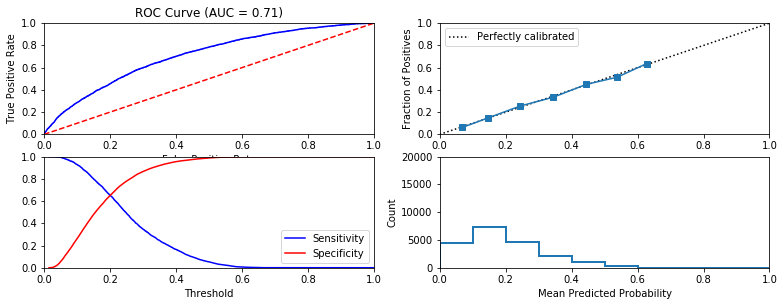


Similarity to LC grade ranking:  0.7158064306344472
Brier score: 0.14422560720150027
Were parameters on edge? : True
Score variations around CV search grid : 0.11593242795627792
[0.80426667 0.80413333 0.80496667 0.80496667 0.805      0.80506667]


In [0]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty='l1')
cv_parameters = {'solver': ['liblinear', 'saga'], 'C':[.1, .5, 1]}

l1_logistic = fit_classification(l1_logistic, data_dict, cv_parameters = cv_parameters, model_name="Logisitic Regression")

### $l_2$ regularized logistic regression

  Model: Logisitic Regression - L2
Fit time: 33.31 seconds
Optimal parameters:
{'C': 1, 'solver': 'lbfgs'}

Accuracy-maximizing threshold was: 0.4904474805677525
Accuracy:  0.8036
              precision    recall  f1-score   support

  No default     0.8109    0.9853    0.8897     16070
     Default     0.5021    0.0606    0.1081      3930

   micro avg     0.8036    0.8036    0.8036     20000
   macro avg     0.6565    0.5229    0.4989     20000
weighted avg     0.7502    0.8036    0.7361     20000



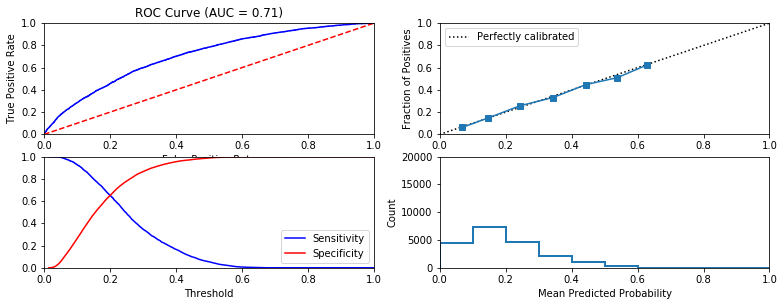


Similarity to LC grade ranking:  0.7129527537033842
Brier score: 0.14423767493472145
Were parameters on edge? : True
Score variations around CV search grid : 0.08693492300050099
[0.8045 0.8045 0.8045 0.8045 0.8045 0.8051 0.8051 0.8051 0.8051 0.8052
 0.8049 0.8049 0.8049 0.8049 0.8051]


In [0]:
## Train and test a l_1 regularized logistic regression classifier

l2_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'solver': ['liblinear', 'saga', 'sag', 'newton-cg', 'lbfgs'], 'C':[.1, 1, 10]}

l2_logistic = fit_classification(l2_logistic, data_dict, cv_parameters = cv_parameters, model_name="Logisitic Regression - L2")

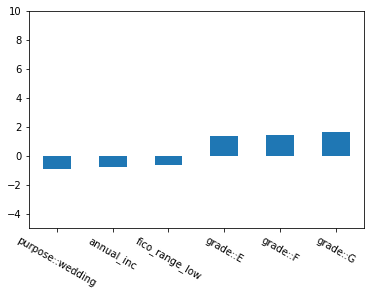

In [0]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: Decision Tree Classifier
Fit time: 5.89 seconds
Optimal parameters:
{'max_depth': 3}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8035
              precision    recall  f1-score   support

  No default     0.8035    1.0000    0.8910     16070
     Default     0.0000    0.0000    0.0000      3930

   micro avg     0.8035    0.8035    0.8035     20000
   macro avg     0.4017    0.5000    0.4455     20000
weighted avg     0.6456    0.8035    0.7160     20000



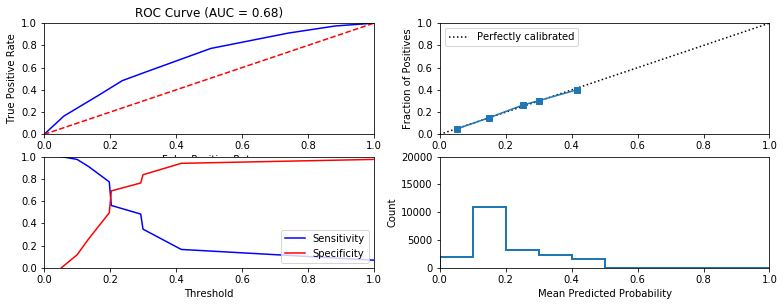


Similarity to LC grade ranking:  0.7787166588431091
Brier score: 0.14770363845538237
Were parameters on edge? : False
Score variations around CV search grid : 13.276648693488182
[0.69806667 0.80366667 0.7769     0.73946667 0.71466667 0.69696667]


In [0]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier()
cv_parameters = {'max_depth':[None, 3, 10, 15, 20, 100]}

decision_tree = fit_classification(decision_tree, data_dict, cv_parameters=cv_parameters, model_name = 'Decision Tree Classifier')

### Random forest

  Model: Random Forest Classifier
Fit time: 30.43 seconds
Optimal parameters:
{'max_depth': 5, 'n_estimators': 10}

Accuracy-maximizing threshold was: 0.3799892945891109
Accuracy:  0.80095
              precision    recall  f1-score   support

  No default     0.8124    0.9781    0.8876     16070
     Default     0.4609    0.0766    0.1314      3930

   micro avg     0.8010    0.8010    0.8010     20000
   macro avg     0.6367    0.5273    0.5095     20000
weighted avg     0.7434    0.8010    0.7390     20000



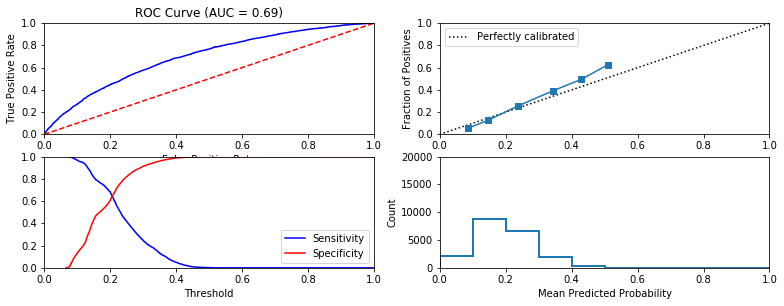


Similarity to LC grade ranking:  0.7620794934264274
Brier score: 0.14664377872096301
Were parameters on edge? : False
Score variations around CV search grid : 4.574296022892209
[0.78053333 0.767      0.79433333 0.79836667 0.8021     0.80363333
 0.8037     0.8037     0.8037     0.8037     0.80363333 0.8037
 0.8037     0.8037     0.8037     0.8028     0.80333333 0.80376667
 0.8037     0.8037     0.78546667 0.79993333 0.8023     0.80333333
 0.8033    ]


In [0]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier()
cv_parameters = {'n_estimators':[2, 5, 10, 20, 50],'max_depth':[None, 2, 3, 5, 10]}

random_forest = fit_classification(random_forest, data_dict, cv_parameters=cv_parameters, model_name = 'Random Forest Classifier')

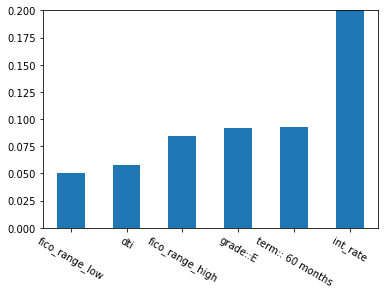

In [0]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: MLP Classifier
Fit time: 437.31 seconds
Optimal parameters:
{'activation': 'logistic', 'hidden_layer_sizes': (16,)}

Accuracy-maximizing threshold was: 0.4773280825758916
Accuracy:  0.80305
              precision    recall  f1-score   support

  No default     0.8104    0.9855    0.8894     16070
     Default     0.4902    0.0570    0.1021      3930

   micro avg     0.8031    0.8031    0.8031     20000
   macro avg     0.6503    0.5212    0.4958     20000
weighted avg     0.7474    0.8031    0.7347     20000



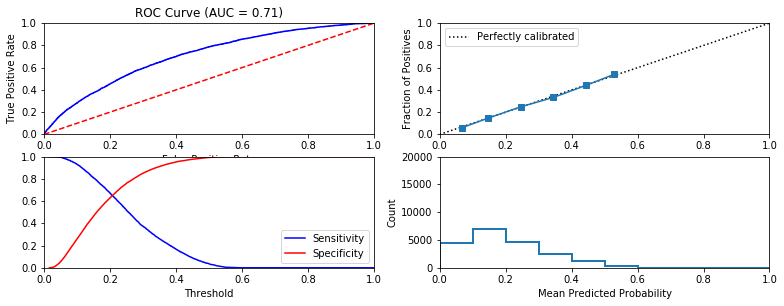


Similarity to LC grade ranking:  0.6968509767058235
Brier score: 0.14444114631609203
Were parameters on edge? : True
Score variations around CV search grid : 2.1795881158579484
[0.80436667 0.80366667 0.80443333 0.80413333 0.79753333 0.7978
 0.8002     0.79853333 0.79483333 0.79846667 0.8003     0.7869    ]


In [0]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier()
cv_parameters = {'activation':['logistic', 'tanh', 'relu'], 'hidden_layer_sizes':[(16, 8, 4,), (16,8,), (16,), (100,)]}

mlp = fit_classification(mlp, data_dict, cv_parameters=cv_parameters, model_name='MLP Classifier')

## Train and Test logistic regression model with features derived by LendingClub

  Model: Logistic Regression - L1 - Single Feature
Fit time: 2.26 seconds
Optimal parameters:
{'C': 0.1, 'solver': 'liblinear'}

Accuracy-maximizing threshold was: 0.4502513698105868
Accuracy:  0.8035
              precision    recall  f1-score   support

  No default     0.8035    1.0000    0.8910     16070
     Default     0.0000    0.0000    0.0000      3930

   micro avg     0.8035    0.8035    0.8035     20000
   macro avg     0.4017    0.5000    0.4455     20000
weighted avg     0.6456    0.8035    0.7160     20000



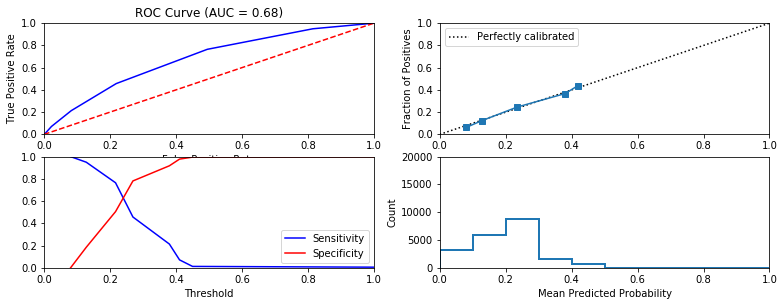


Similarity to LC grade ranking:  1.0
Brier score: 0.1478148089329256
Were parameters on edge? : True
Score variations around CV search grid : 0.08709717556301144
[0.8037 0.8037 0.803  0.803  0.803  0.803 ]


In [0]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = ['grade']

data_dict = prepare_data(feature_subset = a_lendingclub_feature)
lc1_only_logistic = LogisticRegression(penalty='l1')
cv_parameters = {'solver': ['liblinear', 'saga'], 'C':[.1, .5, 1]}

lc1_only_logistic = fit_classification(lc1_only_logistic, data_dict, cv_parameters=cv_parameters, model_name="Logistic Regression - L1 - Single Feature")

  Model: Logistic Regression - L2 - Single Feature
Fit time: 4.91 seconds
Optimal parameters:
{'C': 0.1, 'solver': 'liblinear'}

Accuracy-maximizing threshold was: 0.4014245746842859
Accuracy:  0.8035
              precision    recall  f1-score   support

  No default     0.8035    1.0000    0.8910     16070
     Default     0.0000    0.0000    0.0000      3930

   micro avg     0.8035    0.8035    0.8035     20000
   macro avg     0.4017    0.5000    0.4455     20000
weighted avg     0.6456    0.8035    0.7160     20000



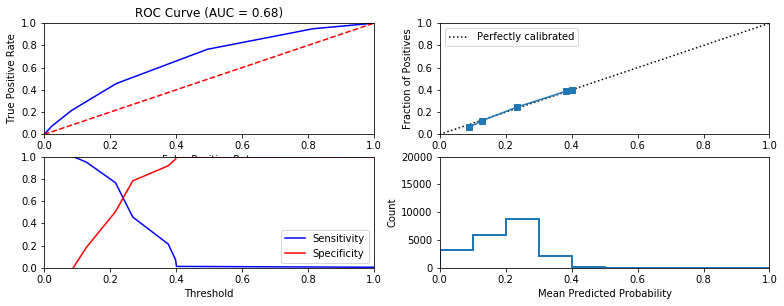


Similarity to LC grade ranking:  1.0
Brier score: 0.147882184516335
Were parameters on edge? : True
Score variations around CV search grid : 0.08709717556301144
[0.8037     0.8037     0.8037     0.8037     0.8037     0.80313333
 0.80313333 0.80313333 0.80313333 0.80313333 0.803      0.803
 0.803      0.803      0.803     ]


In [0]:
## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic = LogisticRegression(penalty='l2')
cv_parameters = {'solver': ['liblinear', 'saga', 'sag', 'newton-cg', 'lbfgs'], 'C':[.1, 1, 10]}

lc2_only_logistic = fit_classification(lc2_only_logistic, data_dict, cv_parameters=cv_parameters, model_name="Logistic Regression - L2 - Single Feature")

## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [0]:
# excluding 'grade' and 'int_rate'  
non_lending_club_features = list(set(your_features) - set(['grade','int_rate']))

data_dict = prepare_data(feature_subset = non_lending_club_features)

In [0]:
gnb_nonlc = GaussianNB()
l1_logistic_nonlc = LogisticRegression(penalty='l1', solver='saga', C=1, random_state=0)
l2_logisitic_nonlc = LogisticRegression(penalty='l2', solver='lbfgs', C=1, random_state=0)
dtc_nonlc = DecisionTreeClassifier(max_depth=3, random_state=0)
rfc_nonlc = RandomForestClassifier(n_estimators=20, max_depth=10, random_state=0)
mlp_nonlc = MLPClassifier(activation='logistic', hidden_layer_sizes=(16,), random_state=0)

model_dict = {'Naive Bayes': gnb_nonlc, 'L1 Logistic': l1_logistic_nonlc, 'L2 Logistic': l2_logisitic_nonlc, 'Decision Tree': dtc_nonlc, 'Random Forest': rfc_nonlc, 'MLP': mlp_nonlc}

In [0]:
model_scores = {}

for n, m in model_dict.items():
  
  acc_scores = []
  roc_scores = []
  
  for i in range(100):
    data_dict = prepare_data(feature_subset = non_lending_club_features, random_state=i)
    model = fit_classification(m, data_dict, model_name=n, print_to_screen=False)
    acc_scores.append(model['accuracy'])
    roc_scores.append(model['ROC'])

  avg_acc = np.mean(acc_scores)
  std_acc = np.std(acc_scores)
  avg_roc = np.mean(roc_scores)
  std_roc = np.std(roc_scores)
  
  model_scores[n] = [avg_acc, std_acc, avg_roc, std_roc]

  print("=======================================================")
  print(n)
  print("=======================================================")
  print("Average Accuracy: ", round(avg_acc, 5), "+/-", round(std_acc,5))
  print("Average ROC: ", round(avg_roc, 5), "+/-", round(std_roc,5))
  print()


Naive Bayes
Average Accuracy:  0.80209 +/- 0.00277
Average ROC:  0.64812 +/- 0.00523

L1 Logistic
Average Accuracy:  0.80288 +/- 0.00286
Average ROC:  0.69093 +/- 0.00425

L2 Logistic
Average Accuracy:  0.80296 +/- 0.00275
Average ROC:  0.69067 +/- 0.00424

Decision Tree
Average Accuracy:  0.80212 +/- 0.00276
Average ROC:  0.64813 +/- 0.00498

Random Forest
Average Accuracy:  0.78869 +/- 0.00431
Average ROC:  0.67779 +/- 0.00429

MLP
Average Accuracy:  0.80296 +/- 0.00285
Average ROC:  0.68757 +/- 0.00409



  Model: Our Model: Non-LC Features
Fit time: 9.52 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.5024496981358255
Accuracy:  0.80435
              precision    recall  f1-score   support

  No default     0.8102    0.9880    0.8903     16070
     Default     0.5211    0.0534    0.0969      3930

   micro avg     0.8044    0.8044    0.8044     20000
   macro avg     0.6656    0.5207    0.4936     20000
weighted avg     0.7534    0.8044    0.7344     20000



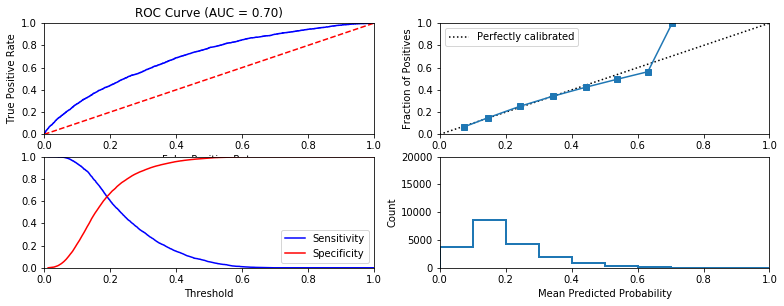


Similarity to LC grade ranking:  0.533555823010856
Brier score: 0.14583452288847884
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.80466667]


In [0]:
data_dict = prepare_data(feature_subset = non_lending_club_features)
our_model = LogisticRegression(penalty='l1', solver='saga', C=1)
our_model_fit = fit_classification(our_model, data_dict, model_name='Our Model: Non-LC Features', print_to_screen=True)

## Time stability test of YOURMODEL

  Model: Our Model : Logisitic Regression
Fit time: 2.57 seconds
Optimal parameters:
{'C': 0.1, 'solver': 'liblinear'}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8804285714285714
              precision    recall  f1-score   support

  No default     0.8804    1.0000    0.9364      6163
     Default     0.0000    0.0000    0.0000       837

   micro avg     0.8804    0.8804    0.8804      7000
   macro avg     0.4402    0.5000    0.4682      7000
weighted avg     0.7752    0.8804    0.8244      7000



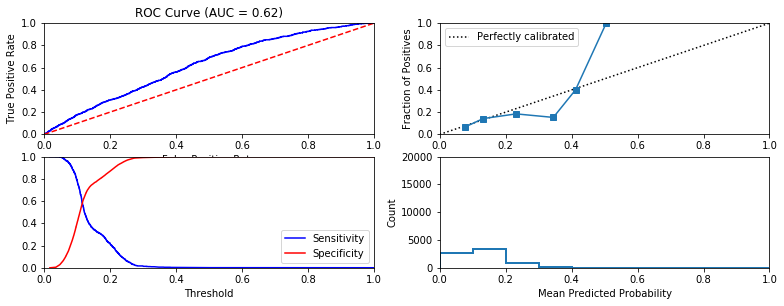


Similarity to LC grade ranking:  0.5779179276656252
Brier score: 0.10410530181778964
Were parameters on edge? : True
Score variations around CV search grid : 0.11348897535667975
[0.88114286 0.88114286 0.88085714 0.88057143 0.88014286 0.88028571]


In [0]:
## Define the time window of your train and test data
## First run with 2010 training data
start_date_train = datetime.datetime.strptime( 'Jan-2010', "%b-%Y").date()
end_date_train = datetime.datetime.strptime( 'Dec-2010', "%b-%Y").date()
start_date_test = datetime.datetime.strptime( 'Jan-2017', "%b-%Y").date()
end_date_test = datetime.datetime.strptime( 'Dec-2017', "%b-%Y").date()

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 7000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data
our_model = LogisticRegression(penalty='l1')
cv_parameters = {'solver': ['liblinear', 'saga'], 'C':[.1, .5, 1]}

our_model_fit = fit_classification(our_model, data_dict_test, cv_parameters=cv_parameters, model_name="Our Model : Logisitic Regression")

  Model: Our Model 2016: Logisitic Regression
Fit time: 4.25 seconds
Optimal parameters:
{'C': 0.1, 'solver': 'liblinear'}

Accuracy-maximizing threshold was: 0.48412672110776184
Accuracy:  0.8575714285714285
              precision    recall  f1-score   support

  No default     0.8924    0.9539    0.9221      6188
     Default     0.2597    0.1232    0.1671       812

   micro avg     0.8576    0.8576    0.8576      7000
   macro avg     0.5761    0.5385    0.5446      7000
weighted avg     0.8190    0.8576    0.8345      7000



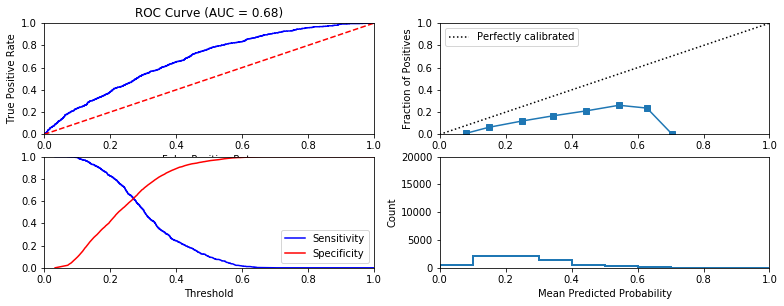


Similarity to LC grade ranking:  0.7469487258910102
Brier score: 0.12062857004286444
Were parameters on edge? : True
Score variations around CV search grid : 0.714823175319792
[0.75942857 0.75828571 0.75471429 0.75471429 0.75457143 0.754     ]


In [0]:
## Run with 2016 training data
start_date_train = datetime.datetime.strptime( 'Jan-2016', "%b-%Y").date()
end_date_train = datetime.datetime.strptime( 'Dec-2016', "%b-%Y").date()
start_date_test = datetime.datetime.strptime( 'Jan-2017', "%b-%Y").date()
end_date_test = datetime.datetime.strptime( 'Dec-2017', "%b-%Y").date()

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 7000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data
our_model = LogisticRegression(penalty='l1')
cv_parameters = {'solver': ['liblinear', 'saga'], 'C':[.1, .5, 1]}

our_model_fit = fit_classification(our_model, data_dict_test, cv_parameters=cv_parameters, model_name="Our Model 2016: Logisitic Regression")

## Train and test YOURMODEL on the original data

Pre-pickled data from Phase 2 to capture data in a state before cleaning and scaling, but after necessary type casting to ensure model runs. All "dirty" data is captured below as pre_data. Added one-hot-encoding and converted 'loan_status' to a binary 'outcome' value.

In [0]:
import pickle
import numpy as np
pre_data, pre_discrete_features, pre_continuous_features = pickle.load( open( "/gdrive/My Drive/Case Study MLPS/pre_clean_data.pickle", "rb" ) )

In [0]:
pre_data["outcome"] = np.where(pre_data['loan_status'].isin(['Charged Off', 'Default']), True, False)

In [0]:
# in this step, we remove features with too many unique values (i.e. 'title' which had over 40,000 unique free-text values) in order to ensure the model runs
import pandas as pd

pre_discrete_cols = []
for f in pre_discrete_features:
  if pre_data[f].nunique() < 25:
    pre_discrete_cols.append(f)

# necessary to one-hot-encode discrete features so that the model runs 
X_continuous_pre = pre_data[list(pre_continuous_features)].values
X_discrete_pre = pd.get_dummies(pre_data[pre_discrete_cols], dummy_na = True, prefix_sep = "::", drop_first = True)

X_discrete_pre = X_discrete_pre.values

pre_X = np.concatenate( (X_continuous_pre, X_discrete_pre), axis = 1 )
pre_y = pre_data.outcome.values

pre_X_train, pre_X_test, pre_y_train, pre_y_test = train_test_split(pre_X, pre_y, test_size=.3)


In [0]:
from sklearn.linear_model import LogisticRegression

## Train and test YOURMODEL using this data
our_model = LogisticRegression(penalty='l1')
our_model.fit(pre_X_train, pre_y_train)
our_pred = our_model.predict_proba(pre_X_test)

In [0]:
our_pred2 = our_model.predict(pre_X_test)

In [0]:
roc_auc_score(pre_y_test, our_pred[:,1])

0.9836979315475219

In [0]:
accuracy_score(pre_y_test, our_pred2)

0.9679089751569834

## Test regression models

In [0]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].as_matrix()
        y_test = data.loc[filter_test, ret_col].as_matrix() 

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                             'predicted_default_return':predicted_default_return,'r2_scores':test_scores}

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### $l_1$ regularized linear regression

In [0]:
data_dict = prepare_data(feature_subset = your_features)

In [0]:
## First, trying l1 regularized linear regression with hyper-parameters

l1_linear = linear_model.LinearRegression()

reg_lasso = fit_regression(l1_linear, data_dict, model_name="Lasso Regression")

  Model: Lasso Regression  Return column: ret_PESS
Fit time: 0.33 seconds
Optimal parameters:
{}

Testing r2 score: 0.03724788270624757
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -0.0
All test scores : [-1.35118978e+20]
  Model: Lasso Regression  Return column: ret_OPT
Fit time: 0.32 seconds
Optimal parameters:
{}

Testing r2 score: 0.021824892368638715
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -0.0
All test scores : [-1.31275709e+20]
  Model: Lasso Regression  Return column: ret_INTa
Fit time: 0.32 seconds
Optimal parameters:
{}

Testing r2 score: 0.039376133531720425
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -0.0
All test scores : [-2.40021642e+20]
  Model: Lasso Regression  Return column: ret_INTb
Fit time: 0.31 seconds
Optimal parameters:
{}

Testing r2 score: 0.03933023767716326
Were parameters on edge (model) : False
Score variations around C

### $l_2$ regularized linear regressor

In [0]:
## trying l2 regularized linear regression with hyper-parameters

l2_linear = linear_model.Ridge()
cv_parameters = {'alpha':[.1, 1, 10, 100]}

reg_ridge = fit_regression(l2_linear, data_dict, cv_parameters=cv_parameters, model_name="Ridge Regression")

  Model: Ridge Regression  Return column: ret_PESS
Fit time: 0.5 seconds
Optimal parameters:
{'alpha': 100}

Testing r2 score: 0.036091586308097834
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -11.578853558430627
All test scores : [-0.13383448 -0.13308319 -0.12820707 -0.1199461 ]
  Model: Ridge Regression  Return column: ret_OPT
Fit time: 0.48 seconds
Optimal parameters:
{'alpha': 100}

Testing r2 score: 0.020858448754837222
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -6.368827397990813
All test scores : [-0.00887651 -0.00875725 -0.00835587 -0.00834503]
  Model: Ridge Regression  Return column: ret_INTa
Fit time: 0.5 seconds
Optimal parameters:
{'alpha': 100}

Testing r2 score: 0.03836723150548693
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -13.967058777785864
All test scores : [-0.11976905 -0.11897342 -0.11372501 -0.10509094]
  Model: Ridge Regression  Ret

### Multi-layer perceptron regressor

In [0]:
## trying multi-layer perceptron regression with hyper-parameters

mlr = MLPRegressor()
cv_parameters = {'activation':['logistic', 'tanh', 'relu'], 'hidden_layer_sizes':[(16, 8, 4,), (16,8,), (16,), (100,)]}

reg_mlp = fit_regression(mlr, data_dict, cv_parameters=cv_parameters, model_name='MLP Regressor')

  Model: MLP Regressor  Return column: ret_PESS
Fit time: 44.68 seconds
Optimal parameters:
{'activation': 'tanh', 'hidden_layer_sizes': (16, 8, 4)}

Testing r2 score: 0.023751170272339195
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -84.35050008856574
All test scores : [-0.13923558 -0.10859115 -0.12776607 -0.12056    -0.10774367 -0.19668138
 -0.15450246 -0.18760686 -0.13470736 -0.14896524 -0.15742801 -0.19862599]
  Model: MLP Regressor  Return column: ret_OPT
Fit time: 44.71 seconds
Optimal parameters:
{'activation': 'logistic', 'hidden_layer_sizes': (16,)}

Testing r2 score: 0.019523658807809485
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -685.0060686473213
All test scores : [-0.02946239 -0.01556614 -0.0066024  -0.03146483 -0.03841603 -0.01296172
 -0.04046051 -0.01819187 -0.01382336 -0.01870656 -0.05167728 -0.05182927]
  Model: MLP Regressor  Return column: ret_INTa
Fit time: 44.54 seconds
Optimal 

### Random forest regressor

In [0]:
## trying random forest regression with hyper-parameters

rfr = RandomForestRegressor()
cv_parameters = {'n_estimators':[2, 5, 10, 20, 50],'max_depth':[None, 2, 3, 5, 10]}

reg_rf = fit_regression(rfr, data_dict, cv_parameters=cv_parameters, model_name='Random Forest Regressor')

  Model: Random Forest Regressor  Return column: ret_PESS
Fit time: 159.64 seconds
Optimal parameters:
{'max_depth': 10, 'n_estimators': 50}

Testing r2 score: 0.044241948981436074
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -519.4545116662637
All test scores : [-0.70952894 -0.35666261 -0.24288679 -0.18233118 -0.15182048 -0.14146423
 -0.13544519 -0.13770133 -0.14079087 -0.1380834  -0.14573572 -0.13800824
 -0.13511484 -0.13283199 -0.13284499 -0.14777181 -0.13217382 -0.1294526
 -0.1190723  -0.12145063 -0.23474641 -0.1628316  -0.13856809 -0.12325707
 -0.11454093]
  Model: Random Forest Regressor  Return column: ret_OPT
Fit time: 155.15 seconds
Optimal parameters:
{'max_depth': 5, 'n_estimators': 50}

Testing r2 score: 0.018108640006829324
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -9745.066696574257
All test scores : [-0.65010268 -0.25715276 -0.1430585  -0.08520309 -0.0491098  -0.016194
 -0.01613818 -

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [0]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the dataframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            # Select num_loans to invest in
            pf_test = num_loans

            # Find the average return for these loans
            ret_test = np.mean(data_test[:pf_test][ret_col])

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = num_loans

            ## Find their return
            ret_test = np.mean(data_test[:pf_test][ret_col])

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = num_loans

            ## Find the average return for these loans
            ret_test = np.mean(data_test[:pf_test][ret_col])

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = num_loans

            ## Find their return
            ret_test = np.mean(data_test[:pf_test][ret_col])

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [0]:
## Test investment strategies using the best performing regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_rand = test_investments(data_dict, regressor=reg_lasso, classifier=l1_logistic, strategy=test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))

strategy: Random
ret_PESS: 0.003643181247051625
ret_OPT: 0.04185929462338522
ret_INTa: 0.01952620210601705
ret_INTb: 0.05513190207281548


In [0]:
test_strategy = 'Default-based'

print('strategy:',test_strategy)
strat_def = test_investments(data_dict, regressor=reg_lasso, classifier=l1_logistic, strategy=test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_def[ret_col]['average return']))

strategy: Default-based
ret_PESS: 0.01996309742233598
ret_OPT: 0.05098787777902832
ret_INTa: 0.020961224426680993
ret_INTb: 0.05481708207671865


In [0]:
test_strategy = 'Return-based'

print('strategy:',test_strategy)
strat_ret = test_investments(data_dict, regressor=reg_lasso, classifier=l1_logistic, strategy=test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_ret[ret_col]['average return']))

strategy: Return-based
ret_PESS: 0.031883880168584254
ret_OPT: 0.04350940291941102
ret_INTa: 0.02192249818373398
ret_INTb: 0.053310209289889686


In [0]:
test_strategy = 'Default-return-based'

## For the Default-return-based strategy we need to fit a new regressor with separate = True
l1_linear_sep = linear_model.LinearRegression()
reg_separate = fit_regression(l1_linear_sep, data_dict, model_name="Lasso Regression", separate=True, print_to_screen=False)

print('strategy:',test_strategy)
strat_defret = test_investments(data_dict, regressor=reg_separate, classifier=l1_logistic, strategy=test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_defret[ret_col]['average return']))

strategy: Default-return-based
ret_PESS: 0.03442041235561199
ret_OPT: 0.044773690367724606
ret_INTa: 0.02841656791507316
ret_INTb: 0.05475944447130236


## Sensitivity test of portfolio size

In [0]:
col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
strategy_dict = {'Random':strat_rand, 'Default-based':strat_def, 'Return-based':strat_ret, 'Default-return-based':strat_defret}
model_dict_reg = {'Lasso': reg_lasso, 'Ridge': reg_ridge, 'MLP': reg_mlp, 'Random Forest': reg_rf}



In [0]:
returns = {k:[] for k in col_list}

for n, s in strategy_dict.items():
  
  print("=======================================================")
  print(n)
  print("=======================================================")
  
  for i in range(100):
    
    data_dict = prepare_data(feature_subset = your_features, random_state=i)
    
    if (n == 'Default-return-based'):
      strat_current = test_investments(data_dict, regressor=reg_separate, classifier=l1_logistic, strategy=n)
    else:
      strat_current = test_investments(data_dict, regressor=reg_lasso, classifier=l1_logistic, strategy=n)
    
    for ret_col in col_list:
      returns[ret_col].append(strat_current[ret_col]['average return'])
  
  for ret_col in col_list:
    avg_ret = np.mean(returns[ret_col])
    std_ret = np.std(returns[ret_col])
    print("Average Return: ", ret_col, ": ", round(avg_ret, 5), "+/-", round(std_ret,5))

  print()

Random
Average Return:  ret_PESS :  0.00465 +/- 0.00286
Average Return:  ret_OPT :  0.04568 +/- 0.00383
Average Return:  ret_INTa :  0.02147 +/- 0.0019
Average Return:  ret_INTb :  0.05659 +/- 0.00227

Default-based
Average Return:  ret_PESS :  0.00605 +/- 0.00315
Average Return:  ret_OPT :  0.04534 +/- 0.00387
Average Return:  ret_INTa :  0.02131 +/- 0.00215
Average Return:  ret_INTb :  0.05691 +/- 0.00249

Return-based
Average Return:  ret_PESS :  0.00975 +/- 0.00606
Average Return:  ret_OPT :  0.04548 +/- 0.00383
Average Return:  ret_INTa :  0.02186 +/- 0.00226
Average Return:  ret_INTb :  0.057 +/- 0.0024

Default-return-based
Average Return:  ret_PESS :  0.01179 +/- 0.00647
Average Return:  ret_OPT :  0.0458 +/- 0.0038
Average Return:  ret_INTa :  0.02217 +/- 0.00225
Average Return:  ret_INTb :  0.05699 +/- 0.00237



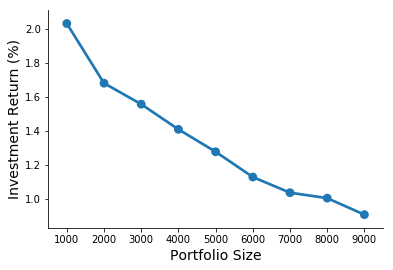

In [0]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []

test_strategy = 'Return-based'

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    reg_0 = test_investments(data_dict, regressor=reg_lasso, classifier=l1_logistic, strategy=test_strategy, num_loans=num_loans)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()